In [66]:
import pandas as pd
preprocessed_dataset_folder = "../Data/PreprocessedDataset"
ratings_df = pd.read_csv(preprocessed_dataset_folder+"/ratings.csv")
movies_df = pd.read_csv(preprocessed_dataset_folder+"/movies.csv")
display(ratings_df.head(10))

,user,item,rating,timestamp
0,17783,5954,5.0,1288572640
1,147353,2805,2.0,979368264
2,32778,1982,4.0,1559214270
3,17160,1225,4.5,1151466878
4,58005,6537,3.0,1112739432
5,133040,736,2.0,1076959711
6,73670,4975,2.0,1415292692
7,118041,1248,4.5,1522631138
8,73268,122904,0.5,1475355740
9,133495,1388,1.0,991281570


In [2]:
display(movies_df.head(5))

,item,title_original,genres,year,title,cast,director,origin,plot
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995,toy story,"tim allen, tom hanks (voices)",john lasseter,american,In a world where toys are living things who pr...
1,2,Jumanji (1995),Adventure|Children|Fantasy,1995,jumanji,"robin williams, bonnie hunt, kirsten dunst, br...",joe johnston,american,"In 1869, near Brantford, New Hampshire, two br..."
2,3,Grumpier Old Men (1995),Comedy|Romance,1995,grumpier old men,"jack lemmon, walter matthau, ann-margret, soph...",howard deutch,american,The feud between Max (Walter Matthau) and John...
3,5,Father of the Bride Part II (1995),Comedy,1995,father of the bride part ii,"steve martin, diane keaton, martin short, kimb...",charles shyer,american,The film begins five years after the events of...
4,6,Heat (1995),Action|Crime|Thriller,1995,heat,"al pacino, robert de niro, val kilmer, ashley ...",michael mann,american,"Neil McCauley, a career criminal, hires Waingr..."


# Movie dataframe preprocessing for content based/matrix factorisation

In [27]:
import pandas as pd
from sklearn.metrics.pairwise import linear_kernel
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import numpy as np

# Tokenize and preprocess plot text
def preprocess_plot_text(plot_text):
    tokens = word_tokenize(plot_text)
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [word.lower() for word in tokens if word.isalnum() and word.lower() not in stop_words]
    return " ".join(filtered_tokens)

movies_df['plot'] = movies_df['plot'].apply(preprocess_plot_text)

In [47]:
def get_user_rated_movies_plots(user):
    selected_user_ratings = ratings_df[ratings_df['user'] == user]
    rated_item_ids = list(selected_user_ratings['item'])
    
    # Filter movies_df based on rated_item_ids
    rated_movies_df = movies_df[movies_df['item'].isin(rated_item_ids)]
    rated_movies_df = rated_movies_df[['item','title', 'plot', 'genres']]
    selected_user_ratings = selected_user_ratings.set_index('item') 
    rated_movies_df = rated_movies_df.join(selected_user_ratings['rating'], on='item')
    return rated_movies_df

In [80]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import ndcg_score

rmse = []
mae = []
ndcg = []
user_list = list(set(ratings_df['user']))
for user in user_list:
    user_plots_ratings_df = get_user_rated_movies_plots(user)
    X = user_plots_ratings_df['plot'] + ' ' + user_plots_ratings_df['title']+ ' ' + user_plots_ratings_df['genres']
    y = user_plots_ratings_df['rating']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    vectorizer = TfidfVectorizer()
    X_train_tfidf = vectorizer.fit_transform(X_train)
    X_test_tfidf = vectorizer.transform(X_test)
    neigh = KNeighborsRegressor(n_neighbors=5)
    neigh.fit(X_train_tfidf, y_train) # train our cassifier
    y_pred = neigh.predict(X_test_tfidf)
    recommendations_df = pd.DataFrame({
        'user': user,
        'predicted_rating': y_pred,
        'actual_rating': y_test.values
    })
    recommendations_df = recommendations_df.sort_values(by=['predicted_rating'], ascending=False).head(10)
    knn_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    knn_mae = mean_absolute_error(y_test, y_pred)
    knn_ndcg = ndcg_score([recommendations_df['actual_rating'].apply(lambda x: 1 if x>3 else 0)], [recommendations_df['predicted_rating'].apply(lambda x: 1 if x>3 else 0)])
    rmse.append(knn_rmse)
    mae.append(knn_mae)
    ndcg.append(knn_ndcg)
    
    

In [81]:
print("KNN RMSE: ", np.mean(rmse))
print("KNN MAE: ", np.mean(mae))
print("KNN NDCG: ", np.mean(ndcg))

KNN RMSE:  0.9407067472141538
KNN MAE:  0.7624136494612104
KNN NDCG:  0.7896527158790524


# Collaborative filtering (KNN)
Let's start by creating a regressor that will predict the user ratings on unseen movies and recommend the ones with the highest predicted ratings for the user

In [52]:
from lenskit.metrics.predict import rmse
from lenskit.algorithms import Recommender
from lenskit.algorithms.user_knn import UserUser # collaborative filtering
from lenskit.algorithms.item_knn import ItemItem # collaborative filtering
from lenskit.algorithms.mf_common import MFPredictor

from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support
import matplotlib.pyplot as plt

# All metrics?
# rmse mae
# average precision, ndcg, rank score

train_dataframe, test_dataframe = train_test_split(ratings_df, test_size=0.2) # 80-20 train test split

user_user = UserUser(15, min_nbrs=3)
item_item = ItemItem(15, min_nbrs=3)

def evaluate_collaborative_filtering(model, train_df, test_df):
    recsys = Recommender.adapt(model)
    recsys.fit(train_df)
    test_df['predicted_rating'] = recsys.predict(test_df)
    test_df['relevant'] = test_df['rating'].apply(lambda x: 1 if x>3 else 0)
    test_df['predicted_relevant'] = test_df['predicted_rating'].apply(lambda x: 1 if x>3 else 0)
    y_test = list(test_df['relevant'])
    y_pred = list(test_df['predicted_relevant'])
    precision, recall, fscore, _ = precision_recall_fscore_support(y_test, y_pred, average="binary")

    print("Precision:\t" + str(precision) +
          "\nRecall:\t" + str(recall) +
          "\nFscore:\t" + str(fscore))
    return precision, recall, fscore

# Let's now plot and compare the two models - user and item based collaborative filtering
precision_user, recall_user, fscore_user = evaluate_collaborative_filtering(user_user, train_dataframe, test_dataframe)
precision_item, recall_item, fscore_item = evaluate_collaborative_filtering(item_item, train_dataframe, test_dataframe)


Numba is using threading layer omp - consider TBB
found 1 potential runtime problems - see https://boi.st/lkpy-perf


Precision:	0.691082479456224
Recall:	0.868545199540992
Fscore:	0.7697175141242937
Precision:	0.6897512437810945
Recall:	0.8838454672956777
Fscore:	0.7748281450846699


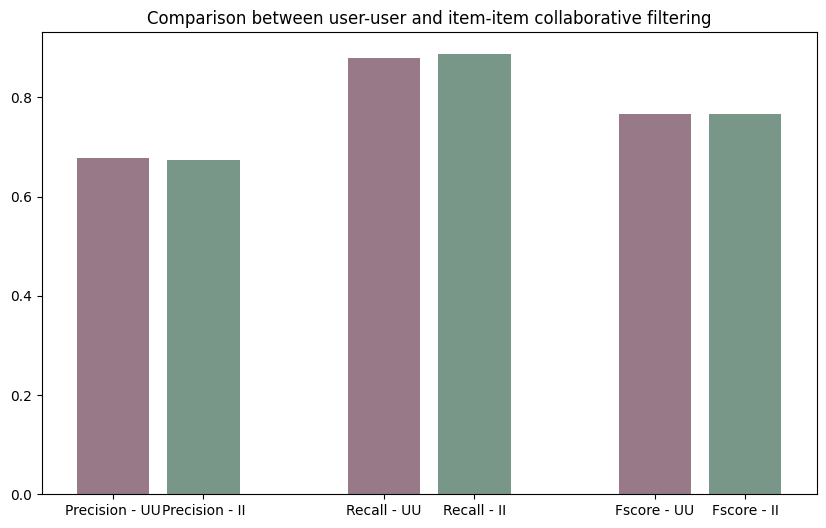

In [8]:

plt.figure(figsize=(10,6))
plt.bar(x = [0, 1 , 3, 4, 6, 7], height = [precision_user, precision_item, recall_user, recall_item, fscore_user, fscore_item], tick_label= ['Precision - UU', 'Precision - II', 'Recall - UU', 'Recall - II', 'Fscore - UU', 'Fscore - II'], color= ["#987987","#789789","#987987","#789789","#987987","#789789"])
plt.title('Comparison between user-user and item-item collaborative filtering')
plt.show()

Now let's check another evaluation method - cross validation with 7 folds with MAE, RMSE , nDCG:

In [96]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
from lenskit.metrics import topn
from lenskit import batch
from sklearn.model_selection import KFold

def evaluate_collaborative_filtering_kfold(model, K):
    kf = KFold(n_splits=K, shuffle=True, random_state=42)

    rmse_list = list()
    mae_list = list()
    ndcg_list = list()

    for train_index, test_index in kf.split(ratings_df):
        train_df = ratings_df.iloc[train_index].copy()
        test_df = ratings_df.iloc[test_index].copy()
        recsys = Recommender.adapt(model)
        recsys.fit(train_df)
        test_df['score'] = recsys.predict(test_df)
        min_score = test_df['score'].min()
        max_score = test_df['score'].max()
        test_df['score'] = 5 * (test_df['score'] - min_score) / (max_score - min_score)
        test_df = test_df.dropna(subset=['score'])
        rmse = np.sqrt(mean_squared_error(test_df['rating'], test_df['score']))
        mae = mean_absolute_error(test_df['rating'], test_df['score'])
        rmse_list.append(rmse)
        mae_list.append(mae)
        for user in test_df['user'].unique():
            user_predictions = test_df[test_df['user'] == user]
            if len(user_predictions) > 1:
                recommendations_df = pd.DataFrame({
                    'user': user,
                    'predicted_rating': test_df[test_df['user']==user]['score'],
                    'actual_rating': test_df[test_df['user']==user]['rating']
                })
                recommendations_df = recommendations_df.sort_values(by=['predicted_rating'], ascending=False).head(10)
                ndcg_value = ndcg_score([recommendations_df['actual_rating'].apply(lambda x: 1 if x>3 else 0)], [recommendations_df['predicted_rating'].apply(lambda x: 1 if x>3 else 0)])
                ndcg_list.append(ndcg_value)

    avg_rmse = np.mean(rmse_list)
    avg_mae = np.mean(mae_list)
    avg_ndcg = np.mean(ndcg_list)

    results = {
        'avg_rmse': avg_rmse,
        'avg_mae': avg_mae,
        'avg_ndcg': avg_ndcg
    }

    print(results)
    return results


In [97]:
user_user_metrics = evaluate_collaborative_filtering_kfold(user_user, 7)
item_item_metrics = evaluate_collaborative_filtering_kfold(item_item, 7)

{'avg_rmse': 0.9195641794934394, 'avg_mae': 0.7371047055972968, 'avg_ndcg': 0.8463714411396968}
{'avg_rmse': 0.9721058252357617, 'avg_mae': 0.7925055171781785, 'avg_ndcg': 0.8480857312835136}
